# Exercise 9.1

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

### (a) Specify the quantum circuits performing the forward and inverse Fourier transform for vectors of length 2 (i.e., acting on a single qubit), and verify your circuits based on the defnition of the Fourier transform.
Hint: Each of your circuits should consist of a single gate.

We use the elegant difinitions form [Quantum Fourier Transform](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#8.-Qiskit-Implementation) instead of my own step-by-step definitions. 

In [2]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

Here we specified the initial quantum state to $|10\rangle$. 

C:\Users\leviliang\anaconda3\envs\pt17_py37\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  


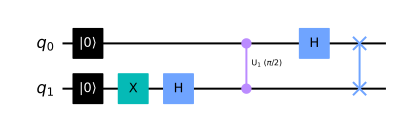

In [3]:
nqubits = 2
qc1 = QuantumCircuit(nqubits)
qc1.reset(0)
qc1.reset(1)

### Encode the state 10 ###
qc1.x(1)
# qc1.x(0)
### Encode the state ###

qc1 = qft(qc1, nqubits)
qc1.draw('mpl')

The state after QFT is as following:

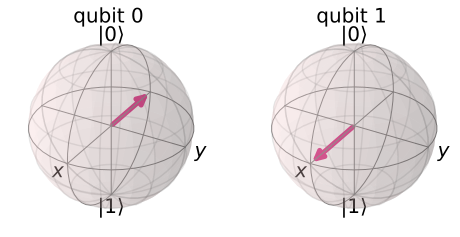

In [4]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc1, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

This is inverse QFT. 

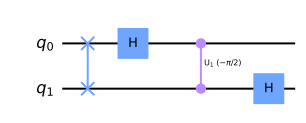

In [5]:
qc2 = QuantumCircuit(nqubits)
qc2 = inverse_qft(qc2, nqubits)
qc2.draw('mpl')

Apply the inverse QFT to the former QFT. 

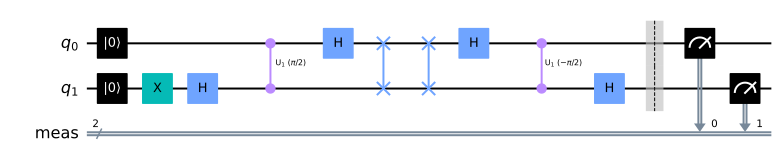

In [6]:
qc3 = QuantumCircuit(nqubits)
qc3 = qc1 + qc2
qc3.measure_all()
qc3.draw('mpl')

The following results show that finally we get $|10\rangle$ again. 

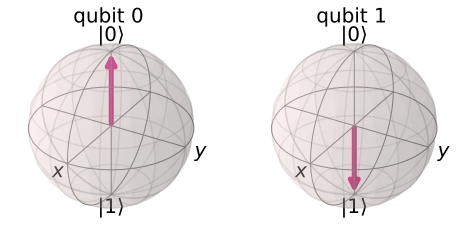

In [7]:
backend = Aer.get_backend("statevector_simulator")
result = execute(qc3, backend=backend, shots=1024, optimization_level=3).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

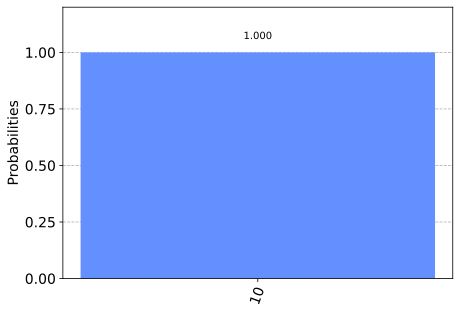

In [8]:
counts = result.get_counts()
plot_histogram(counts)

### (b) Let $U$ be a unitary operator with eigenvalues $\pm1$, which acts on a state $|\psi\rangle$. Using the phase estimation procedure, construct a quantum circuit to collapse $|\psi\rangle$ into one or the other of the two eigenspaces of $U$, giving also a classical indicator as to which space the final state is in. Compare your result with tutorial 3.

Here we use the $\mbox{controlled-}R_2\mbox{ gate}$ that have the rotation degree of $\dfrac{\pi}{2}$. <br/>
Since that $U = \mbox{controlled-}R_2\mbox{ gate} = \begin{bmatrix} 1 & 0 \\ 0 & \mathrm{e}^{\frac{i \pi}{2}} \end{bmatrix}$, <br/>
$$
U |1\rangle = \begin{bmatrix} 1 & 0 \\ 0 & \mathrm{e}^{\frac{i \pi}{2}} \end{bmatrix} |1\rangle = \mathrm{e}^{2 \pi \theta} |1\rangle \\
$$
The eigenspace of $U$ is:
$$
\begin{Bmatrix} |0\rangle, & |1\rangle \end{Bmatrix} = \begin{Bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix}, & \begin{bmatrix} 0 \\ 1 \end{bmatrix} \end{Bmatrix}
$$
And we expect to find:
$$
\theta = \dfrac{1}{4}
$$
Then we build the circuit as follwing:

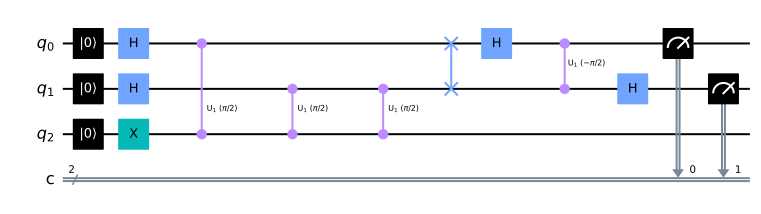

In [9]:
nqubits = 3
pe_qc = QuantumCircuit(nqubits, nqubits-1)

for i in range(nqubits-1):
    pe_qc.reset(i)
    pe_qc.h(i)

### Encode the state 1 ###
pe_qc.reset(nqubits-1)
pe_qc.x(nqubits-1)
### Encode the state ###

for i in range(nqubits-1):
    for j in range(2**i):
        pe_qc.cu1(pi/2, i, nqubits-1)

inv_qft = QuantumCircuit(nqubits-1)
inv_qft = inverse_qft(inv_qft, nqubits-1)

pe_qc.compose(inv_qft ,qubits=range(nqubits-1), inplace=True)
pe_qc.measure(range(nqubits-1), range(nqubits-1))
pe_qc.draw('mpl')

After the following measurement, we get the result of $|01\rangle$ with high possibility. <br/>
That is:
$$
\dfrac{b}{2^t} = \dfrac{1}{2^2} = \dfrac{1}{4} \le \psi
$$
Thus, $\psi = \dfrac{1}{4}$ is what we expect. 

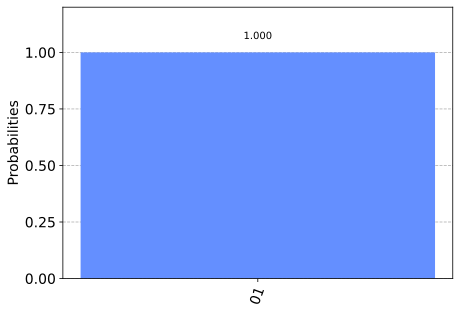

In [10]:
backend = Aer.get_backend('qasm_simulator')
shots = 4096
results = execute(pe_qc, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

Observing the sphere below, we discover that the state of the result is the combination of the eigenstate of $U$, which is consistent with the result in tutorial 3. 

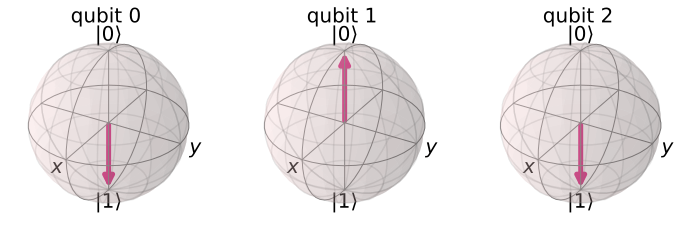

In [11]:
backend = Aer.get_backend("statevector_simulator")
result = execute(pe_qc, backend=backend, shots=1024, optimization_level=3).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)